### Processing handwritten equation with OpenCV

In [324]:
import numpy as np
import tensorflow as tf
import cv2 as cv
import matplotlib.pyplot as plt

In [325]:
image = cv.imread('sevenplusthree.png')
image_working_copy = image.copy()

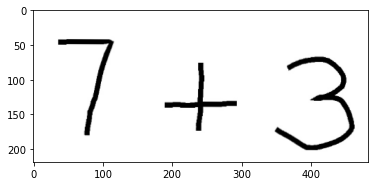

In [326]:
plt.imshow(image)

In [327]:
imgray = cv.cvtColor(image_working_copy, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(imgray, 127, 255, 0)
contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

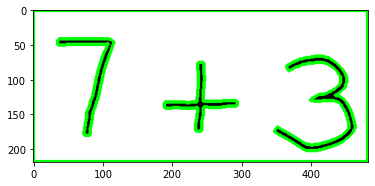

In [328]:
image_with_contours = cv.drawContours(image_working_copy, contours, -1, (0,255,0), 3)

plt.imshow(image_with_contours)

In [329]:
def find_contours(path):
    """
    Finds all contours in a given picture.
    Args:
        path (str): path to image
    Returns:
        contours: Detected contours. Each contour is stored as a vector of points.
        hierarchy: Optional output vector, containing information about the image topology.
    """
    img = cv.imread(path)
    imgray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    ret, thresh = cv.threshold(imgray, 127, 255, 0)
    return cv.findContours(
        thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

In [330]:
contours, hierarchy = find_contours('sevenplusthree.png')

In [335]:
hierarchy

array([[[-1, -1,  1, -1],
        [ 2, -1, -1,  0],
        [ 3,  1, -1,  0],
        [-1,  2, -1,  0]]], dtype=int32)

In [313]:
# create list of tuples
boundingRects = [cv.boundingRect(contour) for contour in contours]

In [314]:
boundingRects

[(0, 0, 483, 219), (189, 75, 106, 100), (348, 66, 117, 137), (35, 41, 82, 140)]

In [338]:
# sortiraj bounding boxeve po prvom elementu tupleova (koordinata X) da dobijes jednadzbu poslozenu po redu 
boundingRects[1][0]

189

In [321]:
(x, y, w, h) = boundingRects[3]

In [322]:
rect_img = cv.rectangle(image_working_copy, (x-10, y-10), (x+w+10, y+h+10), (255, 0, 0), 3)

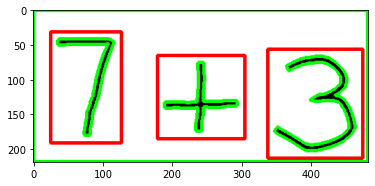

In [323]:
plt.imshow(rect_img)

In [268]:
def find_bounding_rects(image):
    """Finds all contours and chooses ones that best contour given characters.
    Args:
        image (np.ndarray): np.ndarray representation of the image
    Returns:
        list: list of bounding boxes for filtered contours
    """
    contours, hierarchy = find_contours(image)
    boundingRects = [cv.boundingRect(contour) for contour in contours]

    # If 2 bounding boxes are overlapping, take the bigger one
    for i in range(len(boundingRects)):
        if boundingRects[i] is None:
            continue
        for j in range(i + 1, len(boundingRects)):
            if boundingRects[j] is None:
                continue
            x1, y1, width1, height1 = boundingRects[i]
            x2, y2, width2, height2 = boundingRects[j]

            if overlapping_axes(x1, width1, x2, width2) and overlapping_axes(y1, height1, y2, height2):
                if width1 * height1 > width2 * height2:
                    boundingRects[j] = None
                else:
                    boundingRects[i] = None
                    break

    return [bounding for bounding in boundingRects if bounding is not None]

In [269]:
def crop_bounding_box(image, bounding_boxes):
    """Crops images given their bounding boxes
    Args:
        image (np.ndarray): np.ndarray representation of the image
        bounding_boxes (list): bounding box to be used for cropping
    Returns:
        np.ndarray: np.ndarray representation of the cropped image
    """
    cropped_images = list()
    
    for i in range(1, len(bounding_boxes)):
        x, y, width, height = bounding_boxes[i]
        cropped_image = image[(y-10):(y+height+10), (x-10):(x+width+10)]
        cropped_images.insert(0, cropped_image)
    
    return cropped_images

In [270]:
cropped_imgs = crop_bounding_box(image, boundingRects)

In [282]:
# define a function that will resize images to predetermined standard size, which is 150x150 in our case

def resize_images(images_list, pixels_height = 150, pixels_width = 150):
    """This function resizes all images in the given input list to desired 
    pixels height and pixels width.
    
    Args:
        images_list (list): List of images in . 
        pixels_height (int): Desired height of the resized image in pixels.
        pixels_width (int): Desired width of the resized image in pixels.
    Returns:
        resized_imgs (list): List of resized images.
    """
    resized_imgs = []
    
    for image in images_list:
        try:
            resized_image = cv.resize(image, (pixels_height, pixels_width))
            resized_imgs.append(resized_image)
        except:
            break
            
    return resized_imgs

In [283]:
resized_images = resize_images(cropped_imgs)

In [288]:
resized_images_array = np.array(resized_images)

# check for expected output
resized_images_array.shape

(3, 150, 150, 3)

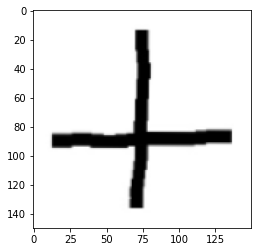

In [291]:
plt.imshow(resized_images[2])

In [292]:
def save_array(numpy_array):
    """This function saves numpy array to a .npy file.
    
    Args:
        numpy_array (ndarray): Array to save in the form of .npy file. 
    """
    np.save(r'output\output_array.npy', numpy_array)

In [293]:
save_array(resized_images_array)

In [272]:
# save image to a .jpg format
result=cv.imwrite(r'C:\Users\Korisnik\git_workspace\MathSolve\Handwritten equation processing\output\output1.jpg', cropped_img)
if result==True:
  print('File saved successfully')
else:
  print('Error in saving file')

File saved successfully
